# MLM states example

## Import packages

The code for computing and plotting background states is contained in the package atmosphere_bgs.

In [1]:
import atmosphere_bgs
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.ndimage import gaussian_filter

## Load the input data

To load the input data use ```atmosphere_bgs.DataLoader```. This defines the target measure, in coordinates $(z,\theta)$, of the optimal transport problem. The target measure is a discretisation of the true mass density in $(z,\theta)$ space. This implementation gives two options for how to define this discretisation.

1. Direct mapping of masses from $(q,\theta)$ space in to $(z,\theta)$ space. For this, define ```nextra```, the number of extra columns of points in $(z,\theta)$ space, and set ```interpolate=False```.
2. Linear interpolation of masses on $\theta$-surfaces in stretched variable. This the default (```interpolate=True```), and the number of intervals used for the linear interpolation on each isentropic surface above ground is specified by ```ny```, whose default value is the number of discrete latitudes are present in the data.

In either case, the minimum pressure value (which should be positive) is set by specifying ```pmin```.

The range of latitudes can be defined by specifying ```smin``` and ```smax```. If ```smax``` is set to ```'critical'``` then ```smax``` is set to the critical value
$$
s_{\mathrm{crit}} := \left(1- \frac{z_{\mathrm{min}}}{a^2\Omega}\right)^{\frac{1}{2}},
$$
where $z_{\mathrm{min}}$ is the minimum zonal angular momentum, which should avoid large negative slopes in the surface pressure.

In [2]:
interpolate=True
ny = None
nextra = 0
pmin =10
smax = 'critical'
smin = None
data = atmosphere_bgs.DataLoader("../data/bs_lc1low2001010000",pmin=pmin,nextra=nextra,ny=ny,smax=smax,smin=smin,interpolate=interpolate)
if interpolate is True:
    print('Number of intervals in interpolation: ', data.ny)

Number of intervals in interpolation:  256


In [3]:
# Check the value of smax
zmin = np.min(data.y[:,0])
earth_radius = data.pp.a
Omega = data.pp.Omega
print('smax-scrit =',np.sqrt(1-zmin/earth_radius**2/Omega)-data.smax)
print('smax =',data.smax)

smax-scrit = 0.0
smax = 0.9980475827924636


The values of zonal angular momentum and potential temperature are stored in the first and second columns of the array ```data.y```, respectively. The corresponding normalised masses are stored in ```data.tmn```, and corresponding values of Ertel PV are stored in ```data.epv```.

In [4]:
z = data.y[:,0]
th = data.y[:,1]
tmn = data.tmn
epv = data.epv

Text(0.5, 1.0, 'Discrete mass distribution in $(z,\\theta)$')

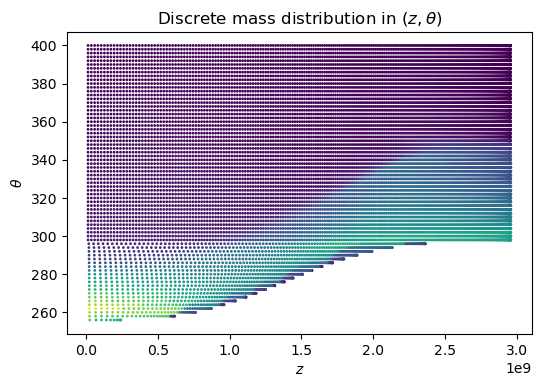

In [5]:
plt.figure(dpi=100)
plt.scatter(z,th,s=1,c=tmn)
plt.xlabel('$z$')
plt.ylabel('$\\theta$')
plt.title('Discrete mass distribution in $(z,\\theta)$')

Text(0.5, 1.0, 'EPV in $(z,\\theta)$')

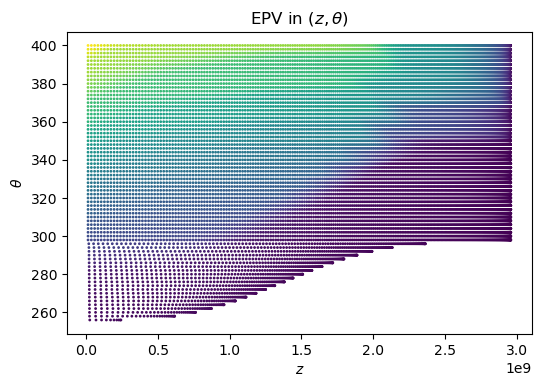

In [6]:
plt.figure(dpi=100)
plt.scatter(z,th,s=1,c=epv)
plt.xlabel('$z$')
plt.ylabel('$\\theta$')
plt.title('EPV in $(z,\\theta)$')

## Get the energy minimising MLM state by solving optimal transport problem

To solve for the energy minimising MLM state:

1. create a solver class instance ```solv``` by passing the input data to the constructor ```atmosphere_bgs.OTSolver```;
2. solve by calling the method ```get_bgs```; this will automatically add the optimal Laguerre tessellation as an attribute to the solver class, which can be used for plotting.

In [7]:
# initialize solver
solv = atmosphere_bgs.OTSolver(data, ot_tol=1e-4, boundary_res=2000)

# here you can adjust parameters as necessary
#solv.sp.min_line_resolution = 8

# run solver
solv.get_bgs(verbose=True);

initial duals calculated
try to fix 0 bad areas
it=-1, lr=1.00e-05, good_areas=14790/14790
it=0, lr=2.00e-05, good_areas=14790/14790, meanerr=2.923716e+00, l2err = 1.060718e+04, max_err=9.769117e+03
it=1, lr=4.00e-05, good_areas=14790/14790, meanerr=2.923599e+00, l2err = 1.060675e+04, max_err=9.768726e+03
it=2, lr=8.00e-05, good_areas=14790/14790, meanerr=2.923365e+00, l2err = 1.060590e+04, max_err=9.767945e+03
it=3, lr=1.60e-04, good_areas=14790/14790, meanerr=2.922897e+00, l2err = 1.060421e+04, max_err=9.766382e+03
it=4, lr=3.20e-04, good_areas=14790/14790, meanerr=2.921962e+00, l2err = 1.060081e+04, max_err=9.763255e+03
it=5, lr=6.40e-04, good_areas=14790/14790, meanerr=2.920090e+00, l2err = 1.059402e+04, max_err=9.757003e+03
it=6, lr=1.28e-03, good_areas=14790/14790, meanerr=2.916346e+00, l2err = 1.058044e+04, max_err=9.744497e+03
it=7, lr=2.56e-03, good_areas=14790/14790, meanerr=2.908843e+00, l2err = 1.055328e+04, max_err=9.719487e+03
it=8, lr=5.12e-03, good_areas=14790/14790, me

Physical parameters defining the cost function have default parameters in the C++ source code and do not have to be changed. 

The extent of the physical domain in $(s,p)$ coordinates is set depending on the input data:

- ```smin```: set to the minimum sine latitude value;
- ```smax```: set to the maximum sine latitude value;
- ```pmin```: defined when loading the input data;
- ```pmax```: default is 1.4 times the reference pressure (this is $141855$).

In addition, there are other simulation parameters that determine e.g. to what precision the Laguerre diagrams are constructed. Some parameters of interest are:

- ```min_line_resolution```: the minimum number of points used to discretise a boundary segment of a Laguerre cell (this must be at least 2),
- ```line_tolerance```: the maximum area error induced by discretising a boundary segment of a Laguerre cell,
- ```boundary_res```: the resolution of the surface pressure,
- ```area_tolerance```: the maximum relative error of the computed area of a Laguerre cell.

A relative area tolerance ```ot_tol``` can be passed to the optimal transport solver. The default value is ```1e-4```.

# Extraction of the pressure at the lower boundary
The pressure at the lower boundary can be obtained as a function of $s=\sin(\phi)$, where $\phi$ is latitude, by extracting the coorindates of points on the boundary of the 'top' Laguerre cell.

In [8]:
# get the (s,p) coordinates of points on the boundary of the 'top' Laguerre cell
n = solv.y.shape[0]
edges = [e for e in solv.ld.edglist if e.pj >= n+6]
edge_pts = np.unique(np.vstack([e.ls.x for e in edges]),axis=0)

# sort the points accending in their s coordinate
idx = np.argsort(edge_pts[:,0])
pressure_surface = edge_pts[idx]

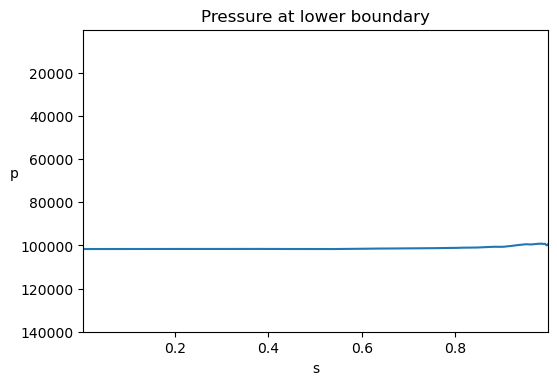

In [9]:
# Plot of pressure at the lower boundary
fig, ax = plt.subplots(1,1,dpi=100)
ax.plot(pressure_surface[:,0],pressure_surface[:,1])
ax.set_xlim([data.smin,data.smax])
ax.set_ylim([data.pmin,140000])
ax.set_xlabel('s')
ax.set_ylabel('p',rotation=0)
ax.set_title('Pressure at lower boundary')
ax.invert_yaxis()

# Manual rasterization

To get rasterized matrix from the Laguerre diagram, there is a `Rasterizer` class. Each `LaguerreDiagram` defines a method ```get_rasterizer``` that returns such a `Rasterizer` and can optionally take a $\mathbb{R}^2 \to \mathbb{R}^2$ transformation which is applied to the diagram beforehand, e.g.

In [10]:
rast = solv.ld.get_rasterizer()
#rast = solv.ld.get_rasterizer(lambda x : [np.rad2deg(np.arcsin(x[0])), np.log10(x[1])])

fixed 0 intersects


The function `Rasterizer.rasterize` can be used to calculate regular-grid rasterized functions defined piecewise constant on the Laguerre cells.
The first argument is an array of function values, the second is the desired resolution.
For pixels intersecting multiple Laguerre cells, the value is set to the linear combination weighted by the intersecting areas.

Some pixels will intersect the surface pressure. The matrix ```rast.fill``` has the same shape as the rasterized result, and each entry is the fraction of the corresponding pixel that is within the physical domain (i.e., with pressure less than the surface pressure). This can be used to normalize the rasterized values. Note that the matrix returned by `rasterize` is a reference to internal memory of the rasterizer, if you want to continue using the returned matrix, you should take a copy to prevent errors.

To smooth the result, the function `scipy.ndimage.gaussian_filter` can be used as demonstrated below. To get the correct results on the boundary, both the rasterized values and the fill matrix should be smoothed with the same kernel.

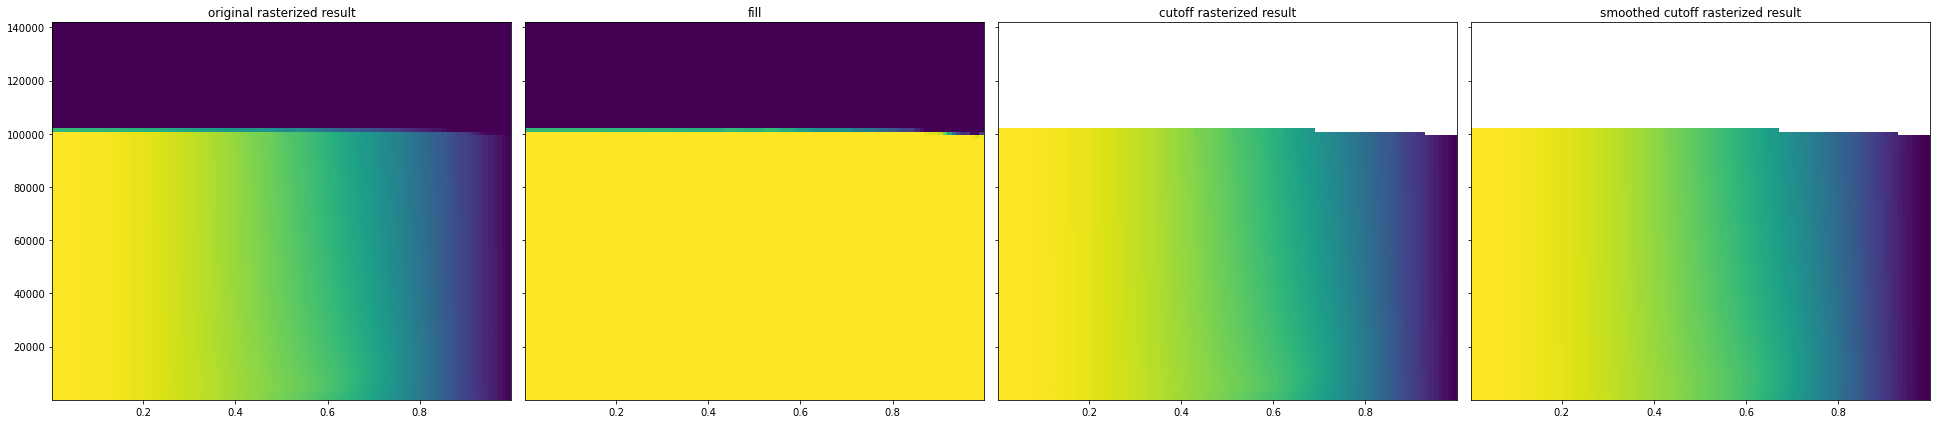

In [11]:
val = solv.y[:,0]

a = rast.rasterize(val, (100, 100)).copy()

fill = rast.fill.copy()

# set pixels that are less than half filled to nan
b = np.where(fill > 0.5, np.divide(a, fill, where=(fill > 0)), np.nan)

# use a gaussian filter to smooth the rasterized image
a_smooth = gaussian_filter(a, sigma=3)
fill_smooth = gaussian_filter(fill, sigma=3)
b_smooth = np.where(fill_smooth > 0.5, np.divide(a_smooth, fill_smooth, where=(fill_smooth > 0)), np.nan)

# example plot
fig, axs = plt.subplots(1, 4, figsize=(27,6), sharex=True, sharey=True, tight_layout=True)

axs[0].imshow(a.T, extent=rast.bounds, aspect="auto", origin="lower")
axs[0].set_title("original rasterized result")

axs[1].imshow(fill.T, extent=rast.bounds, aspect="auto", origin="lower")
axs[1].set_title("fill")

axs[2].imshow(b.T, extent=rast.bounds, aspect="auto", origin="lower")
axs[2].set_title("cutoff rasterized result")

axs[3].imshow(b_smooth.T, extent=rast.bounds, aspect="auto", origin="lower")
axs[3].set_title("smoothed cutoff rasterized result")

plt.show()

## Using the built-in plot function

There is also a predefined function for plotting Laguerre tesselations, namely ```atmosphere_bgs.plot_lag_tess```. It takes a `LaguerreDiagram` instance ```ld``` and a vector of values ```val``` for each Laguerre cell (e.g. potential temperature) and plots the corresponding Laguerre tessellation with colour corresponding to ```val```. The optimal Laguerre tessellation found by solving the optimal transport problem with given  data is automatically saved as an attribute of the solver class, here called ```bgs```.

Independent, continuous, injective transformations of the axes can be passed as ```transform```. Below this is done with the transformation
$$
(s,p)\mapsto (\phi,z) = \left(\arcsin(s),-H\ln\left(\frac{p}{p_{00}}\right)\right),
$$
where $H=6500$.

By default values are set to be constant on each Laguerre cell. If a non-zero bandwidth ```bw``` is passed then the rasterized values are smoothed (in the transformed coordinates if specified) using a Gaussian kernel via the function ```gaussian_filter``` imported from the package ```scipy.ndimage```.

The rasterized values ```rv``` and current axes ```ax``` are returned. The resolution of the rasterization can be specified by passing ```res``` to the plotting function. The default value is ```res=(1000,1000)```, which specifies a $1000\times 1000$ grid.

### Define transformation from $(s,p)$ to $(\phi,z)$

In [12]:
transform = lambda x : [np.rad2deg(np.arcsin(x[0])), -6500*np.log(x[1]/solv.pp.p00)]

In [13]:
# Arguments for plotting in (s,p) and (lat,z) space
kwargs_s_p = {'ld' : solv.ld, 'plot_lines' : True, 'background' : True, 'invert_yaxis' : True}
kwargs_lat_z = {'ld' : solv.ld, 'transform' : transform, 'bw' : 30, 'contour_levels' : 10,
                'plot_lines' : False, 'background' : True, 'invert_yaxis' : False}

### Plot velocity (piecewise constant and smoothed)

The velocities at Laguerre cell centroids are computed by passing the Laguerre diagram to the function ```atmosphere_bgs.get_u```. This returns a vector of values with each component being the $u$ value of the corresponding cell centroid.

In [14]:
# Compute velocity at cell centroids
u = atmosphere_bgs.get_u(solv.ld)

fixed 0 intersects


Text(0, 0.5, '$p$')

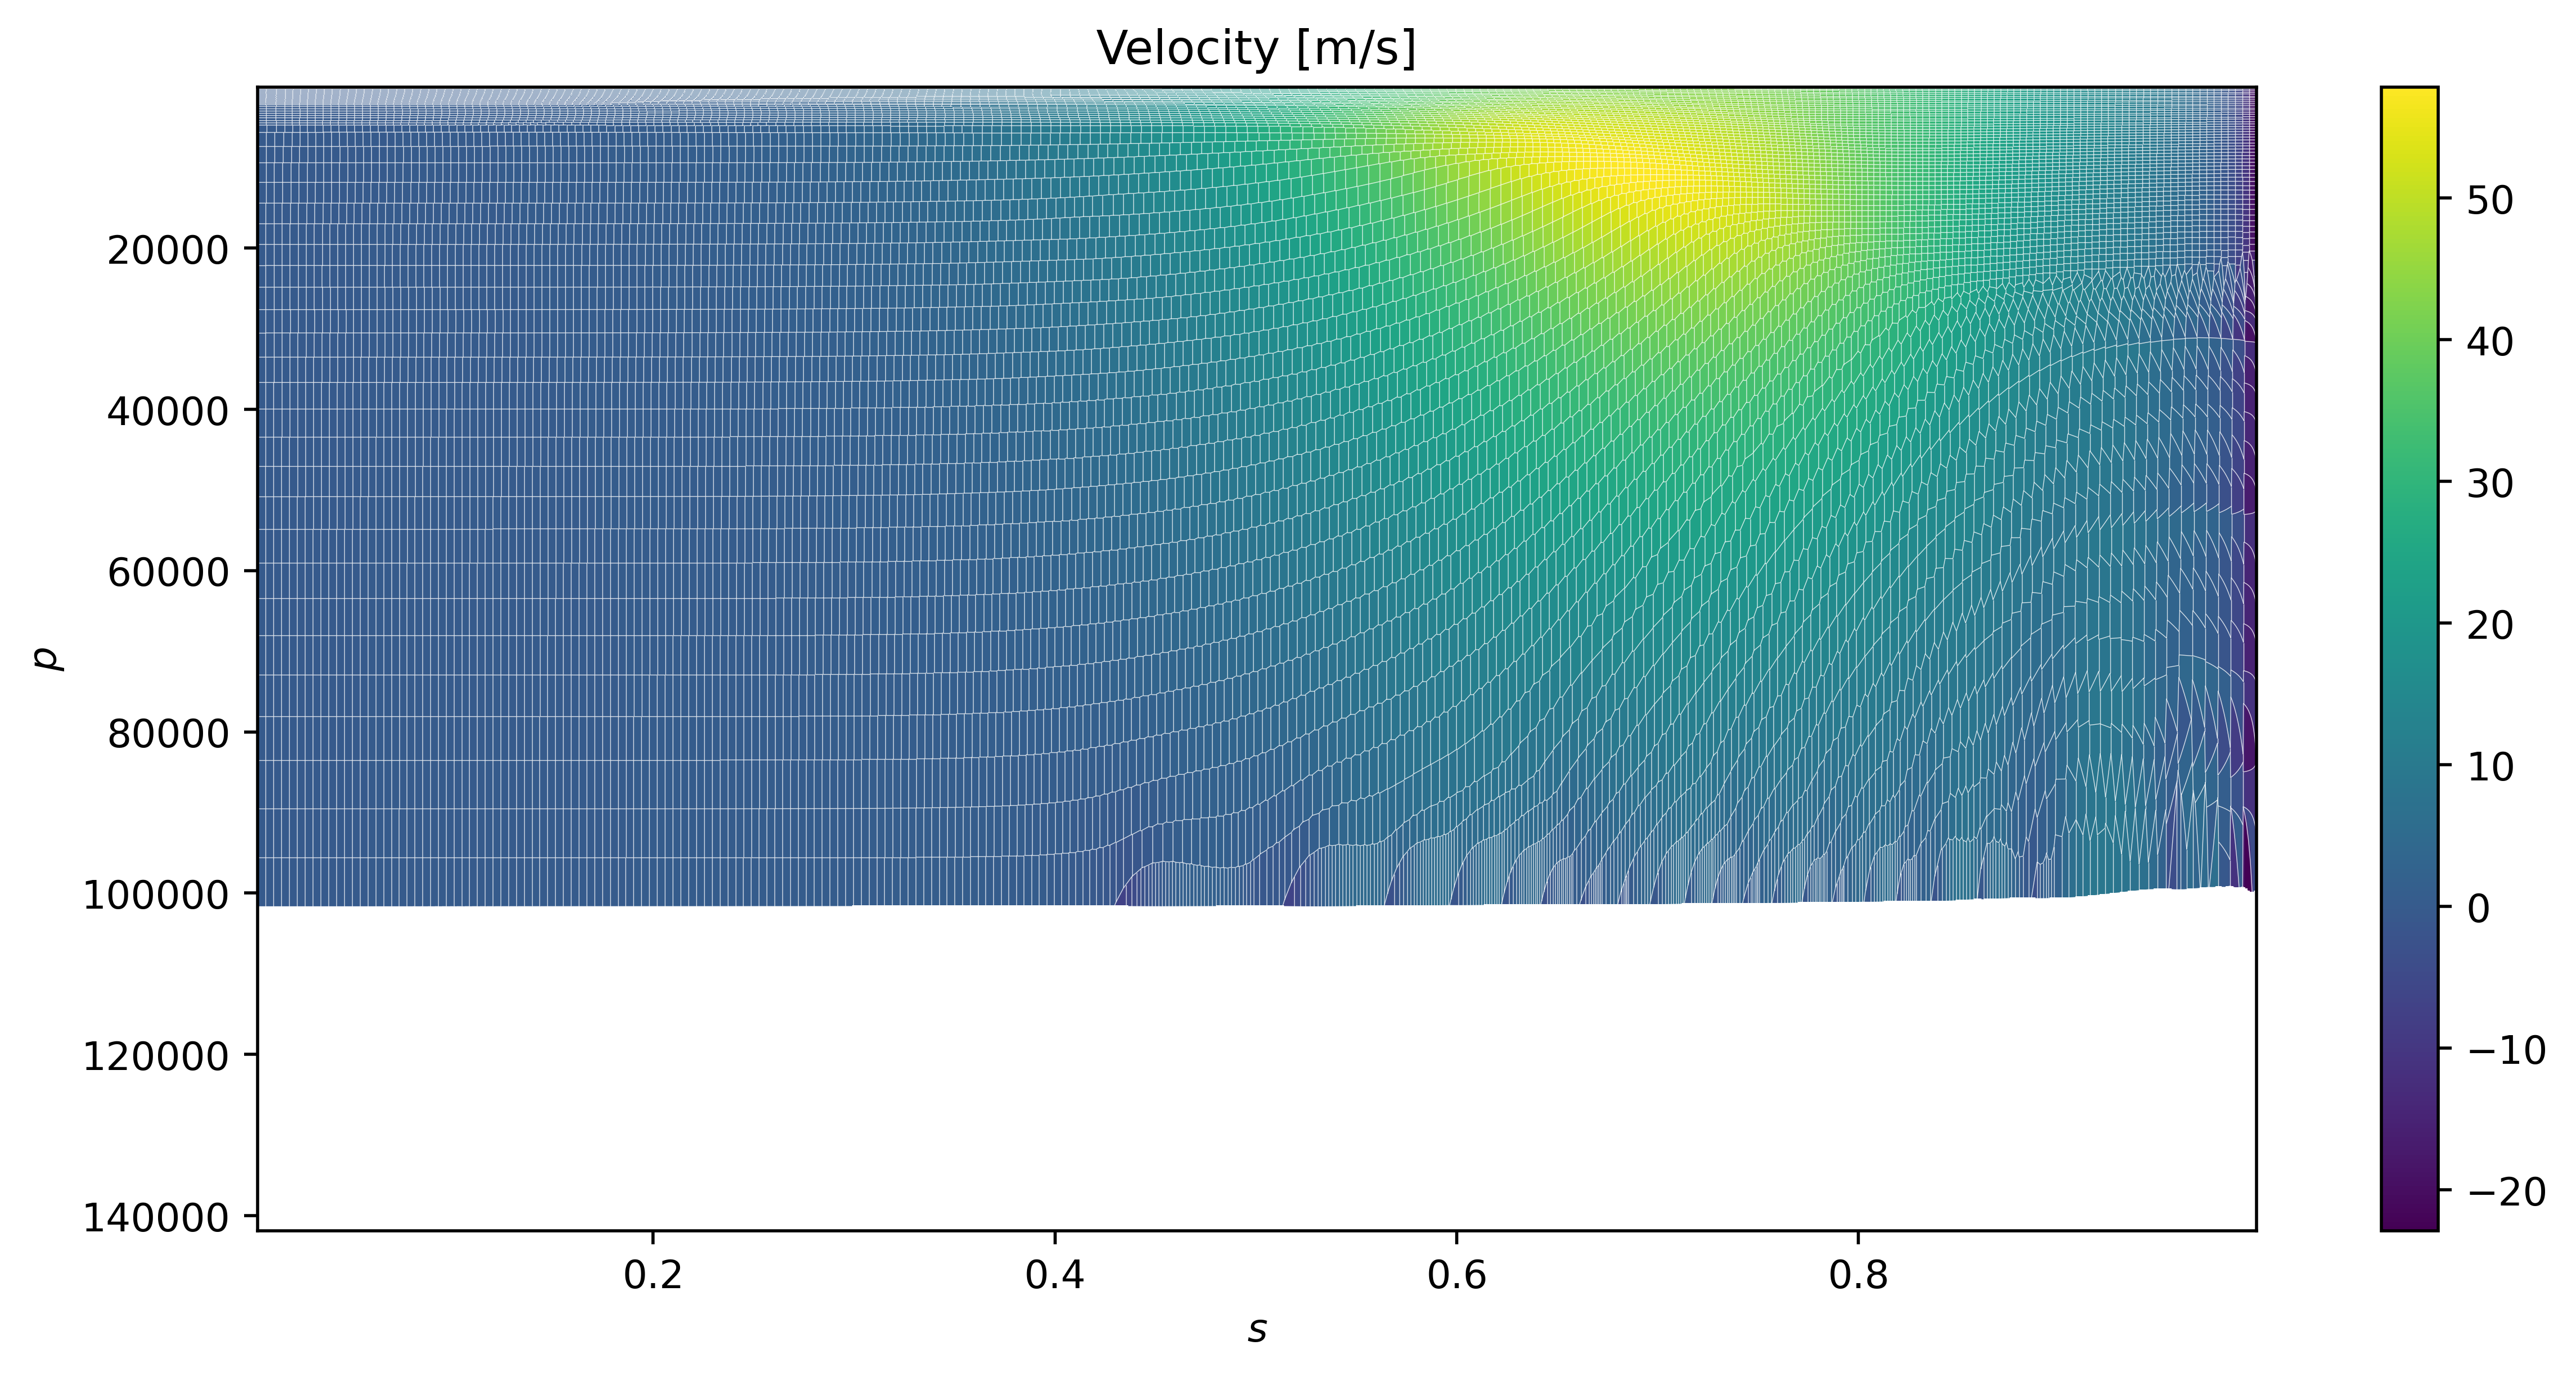

In [15]:
# The plotting function returns rasterized values and the figure axes
rv, ax = atmosphere_bgs.plot_lag_tess(val=u, title='Velocity [m/s]', **kwargs_s_p)
ax.set_xlabel('$s$')
ax.set_ylabel('$p$')

fixed 0 intersects


Text(0, 0.5, '$z$')

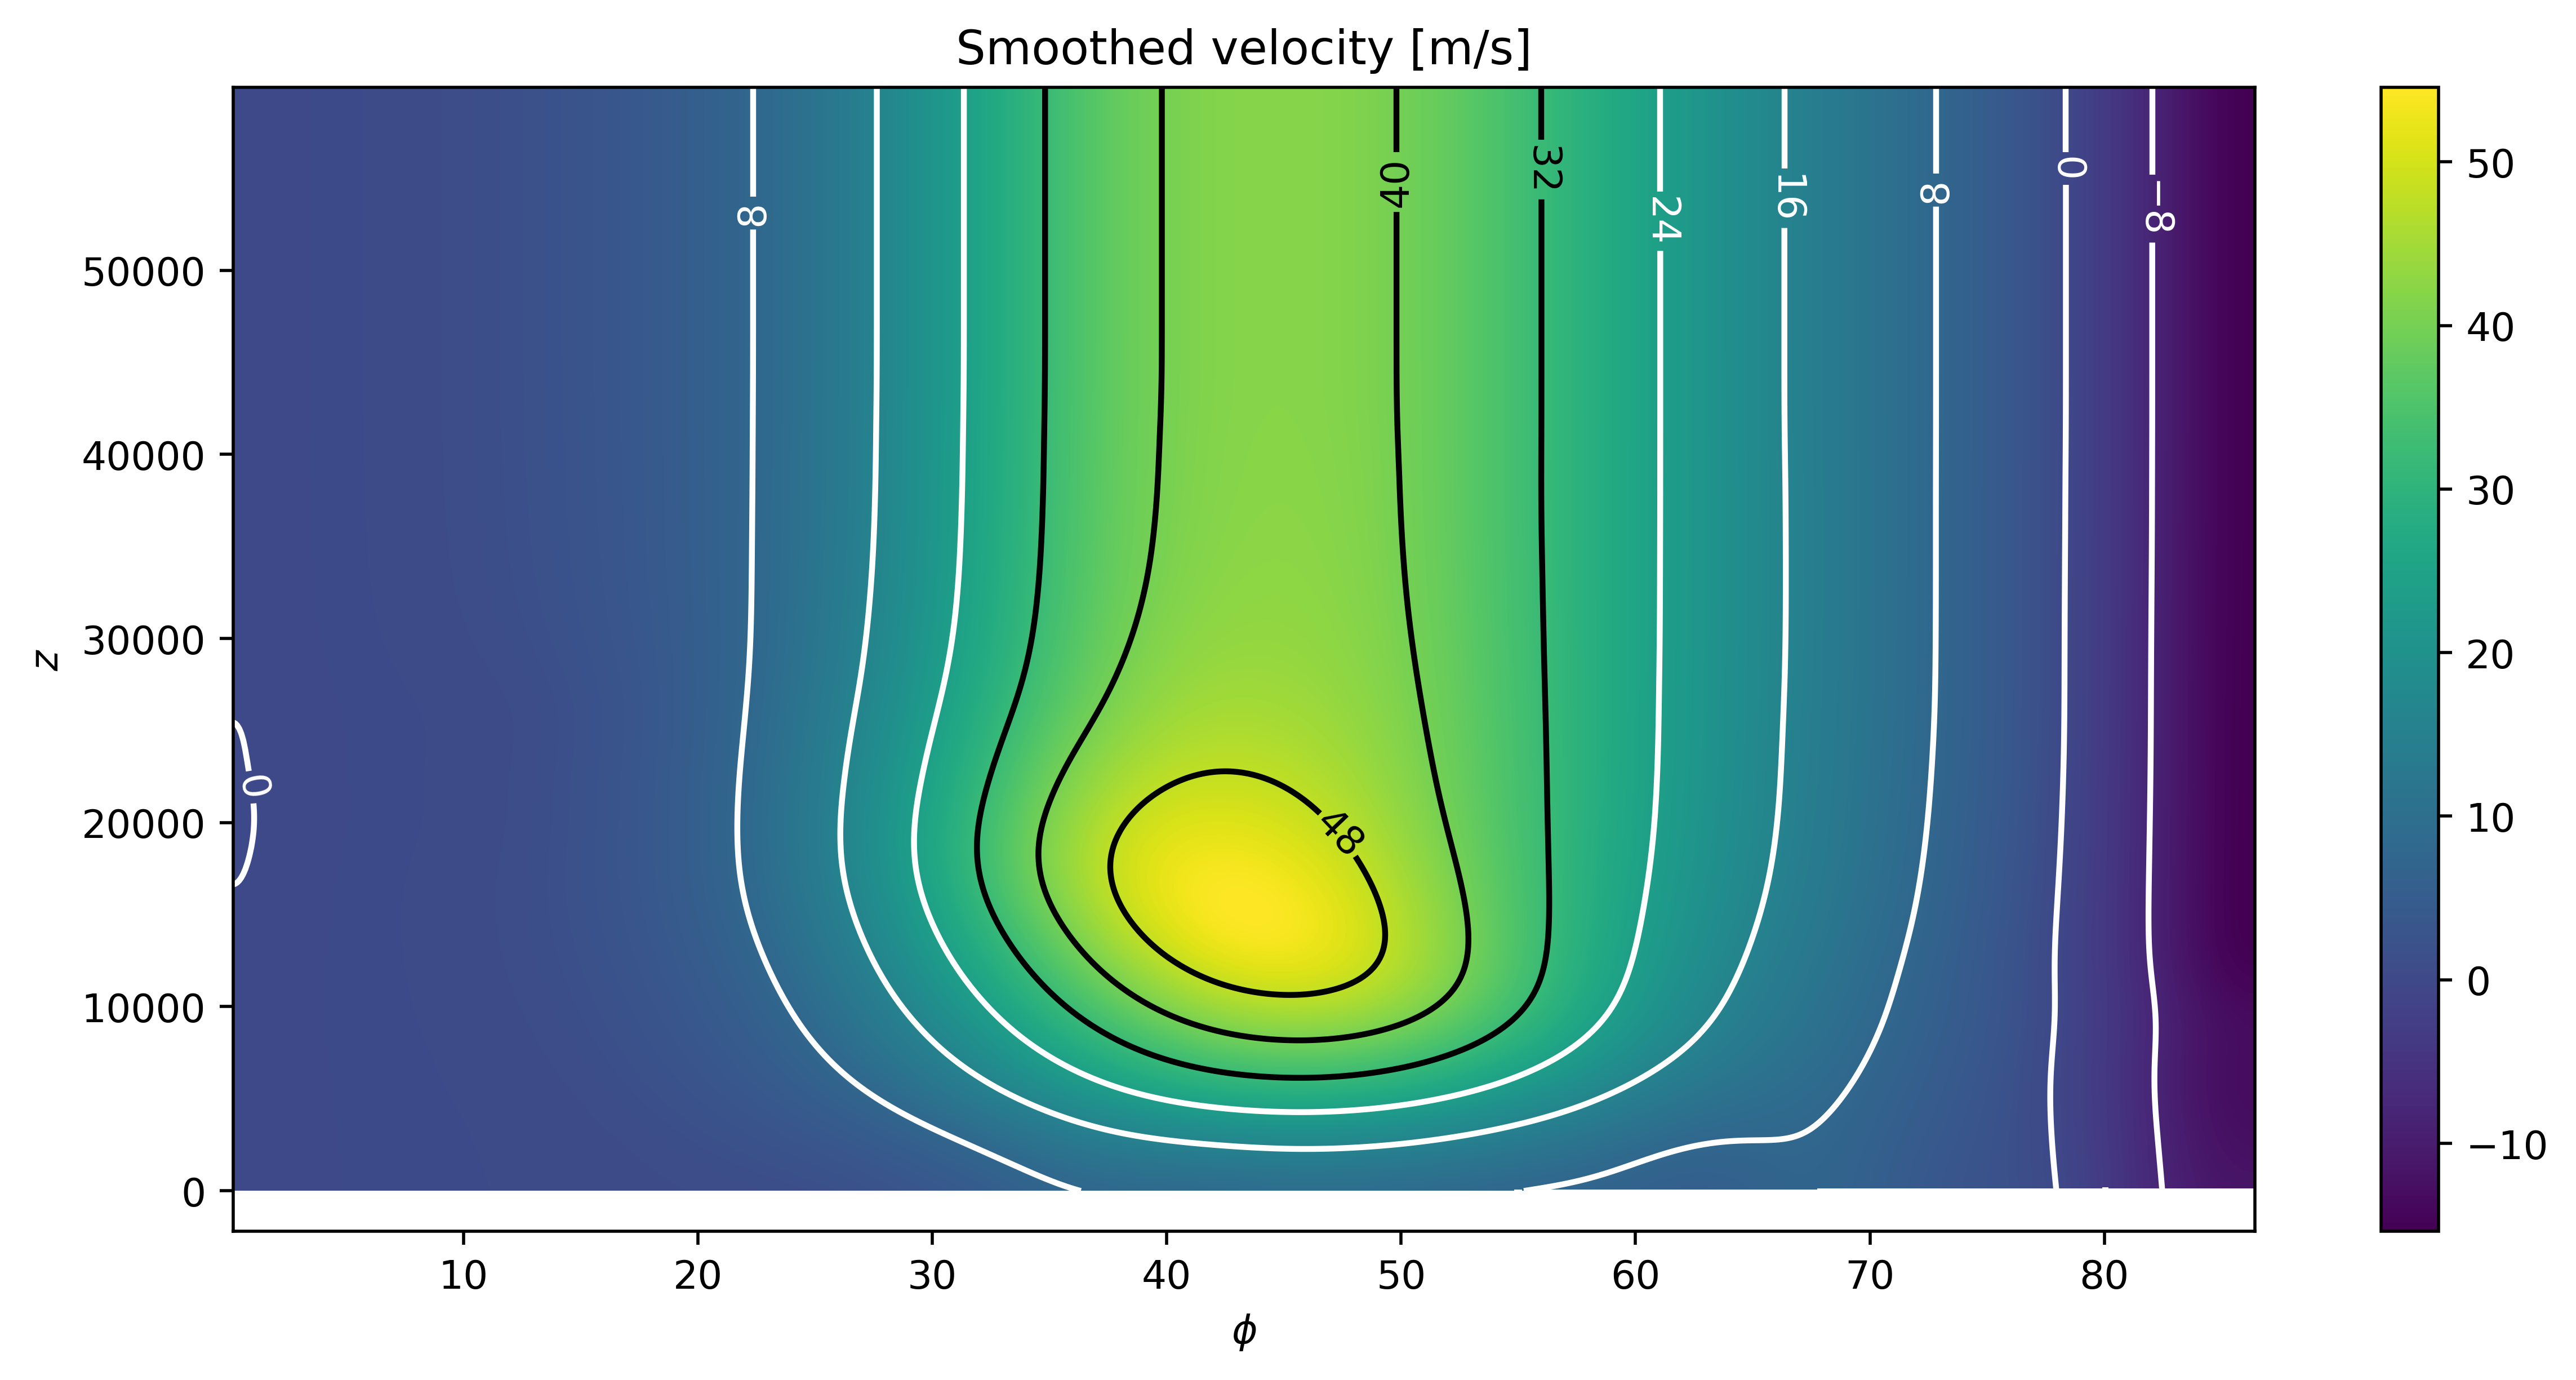

In [16]:
rv, ax = atmosphere_bgs.plot_lag_tess(val=u, title='Smoothed velocity [m/s]', **kwargs_lat_z)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$z$')

### Plot zonal angular momentum (piecewise constant and smoothed)

The zonal angular momentum values are the first coordinates of the 'seed' positions ```solv.y```. (The potential temperature values are the second coordinates of the seeds.)

fixed 0 intersects
fixed 0 intersects


Text(0, 0.5, '$z$')

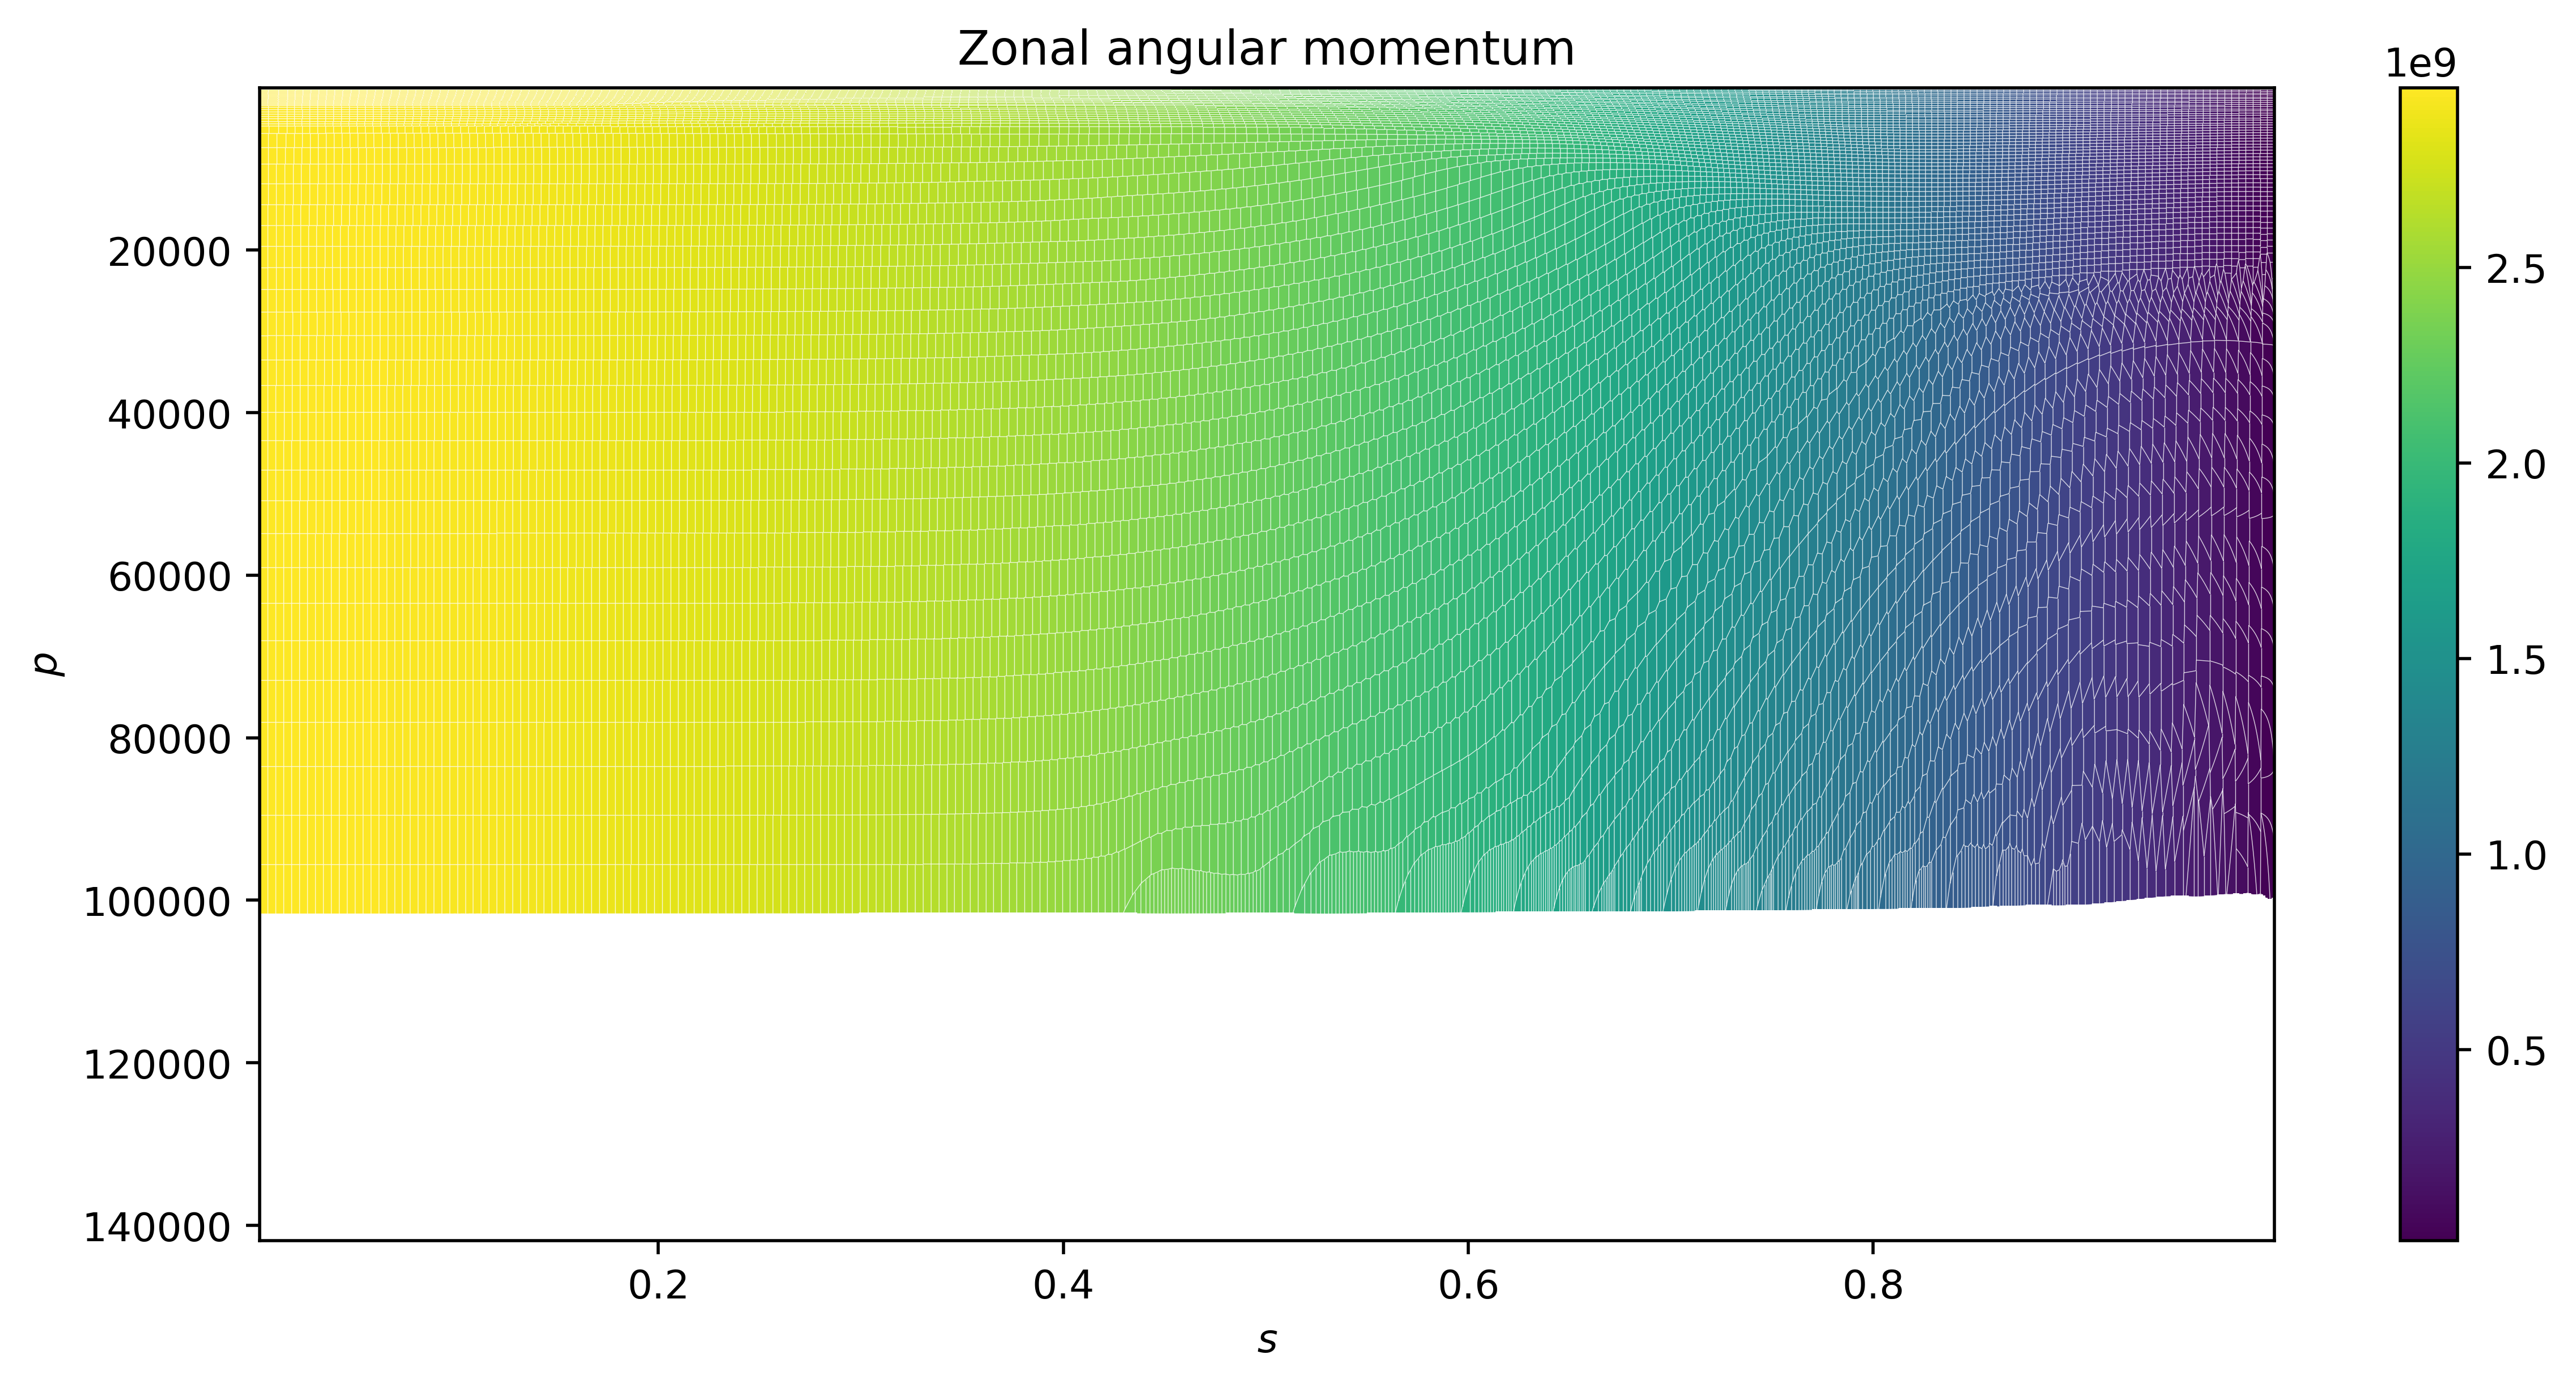

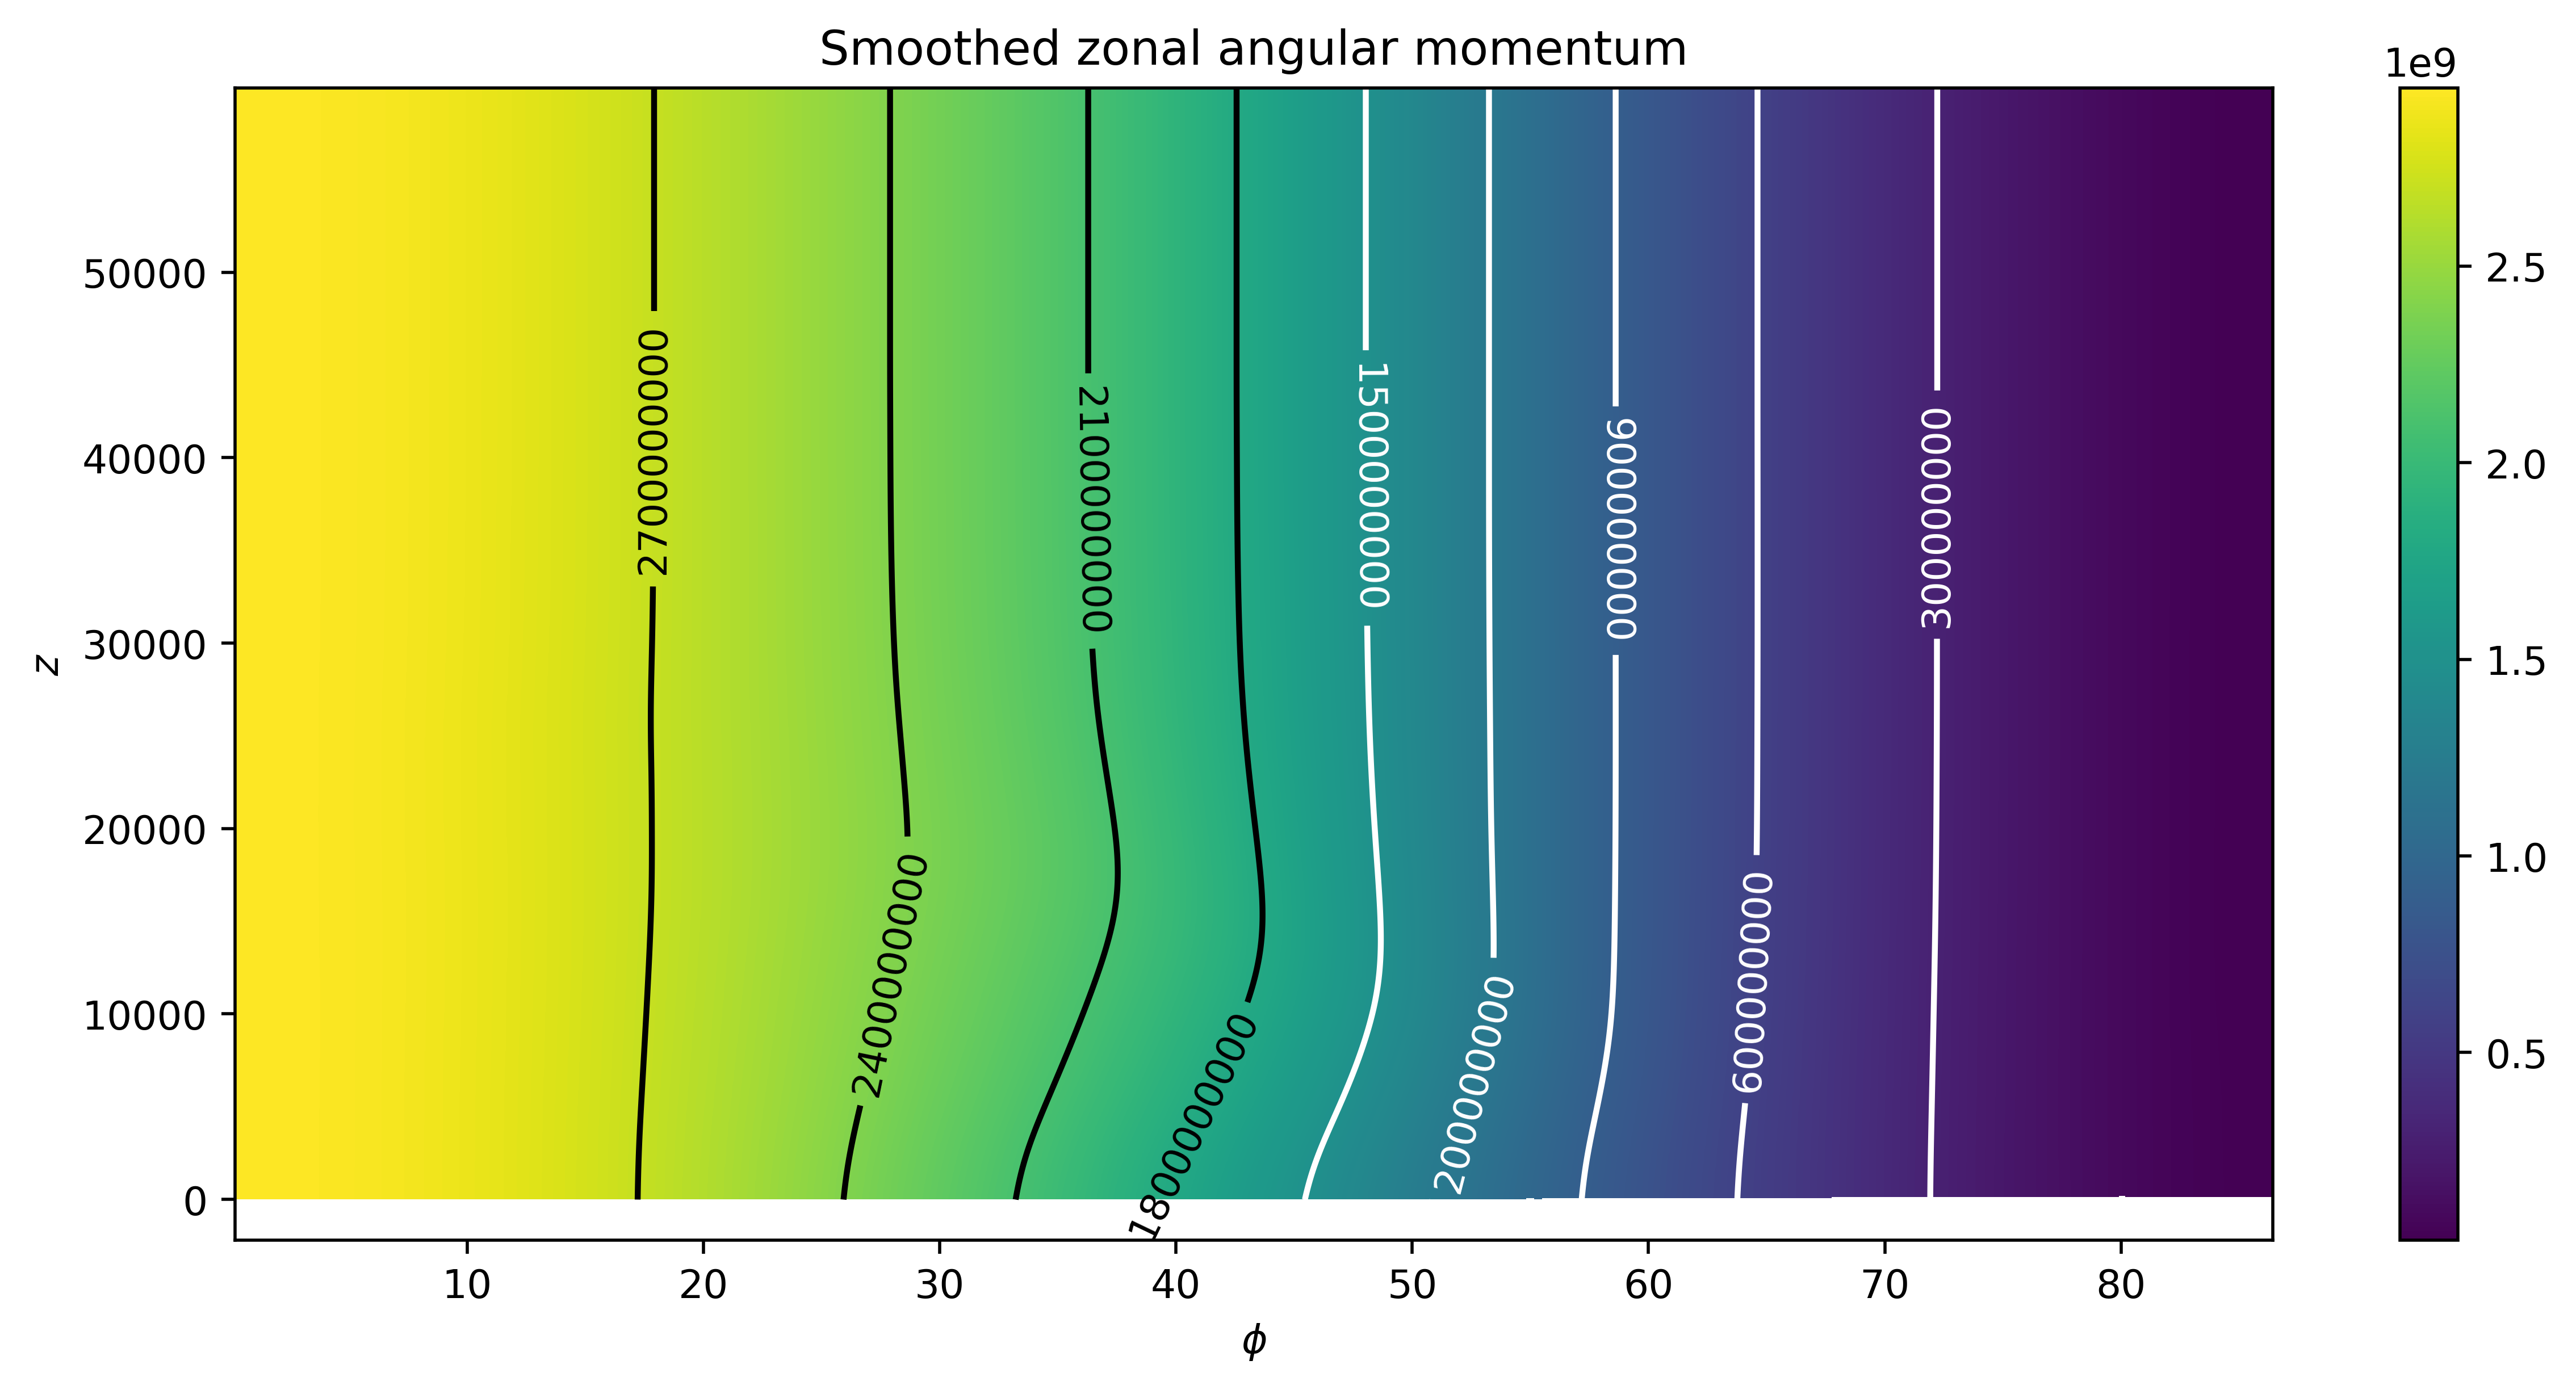

In [17]:
rv, ax = atmosphere_bgs.plot_lag_tess(val=solv.y[:,0], title = 'Zonal angular momentum', **kwargs_s_p)
ax.set_xlabel('$s$')
ax.set_ylabel('$p$')

rv, ax = atmosphere_bgs.plot_lag_tess(val=solv.y[:,0], title = 'Smoothed zonal angular momentum', **kwargs_lat_z)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$z$')

### Plot Ertel potential vorticity (piecewise constant and smoothed)

The Ertel potential vorticity is saved as the atribute ```epv``` of the data loader class ```data``` and is a vector whose length is equal to the number of seeds. The entry ```epv[i]``` is the Ertel PV of the $i$-th Laguerre cell.

fixed 0 intersects
fixed 0 intersects


Text(0, 0.5, '$z$')

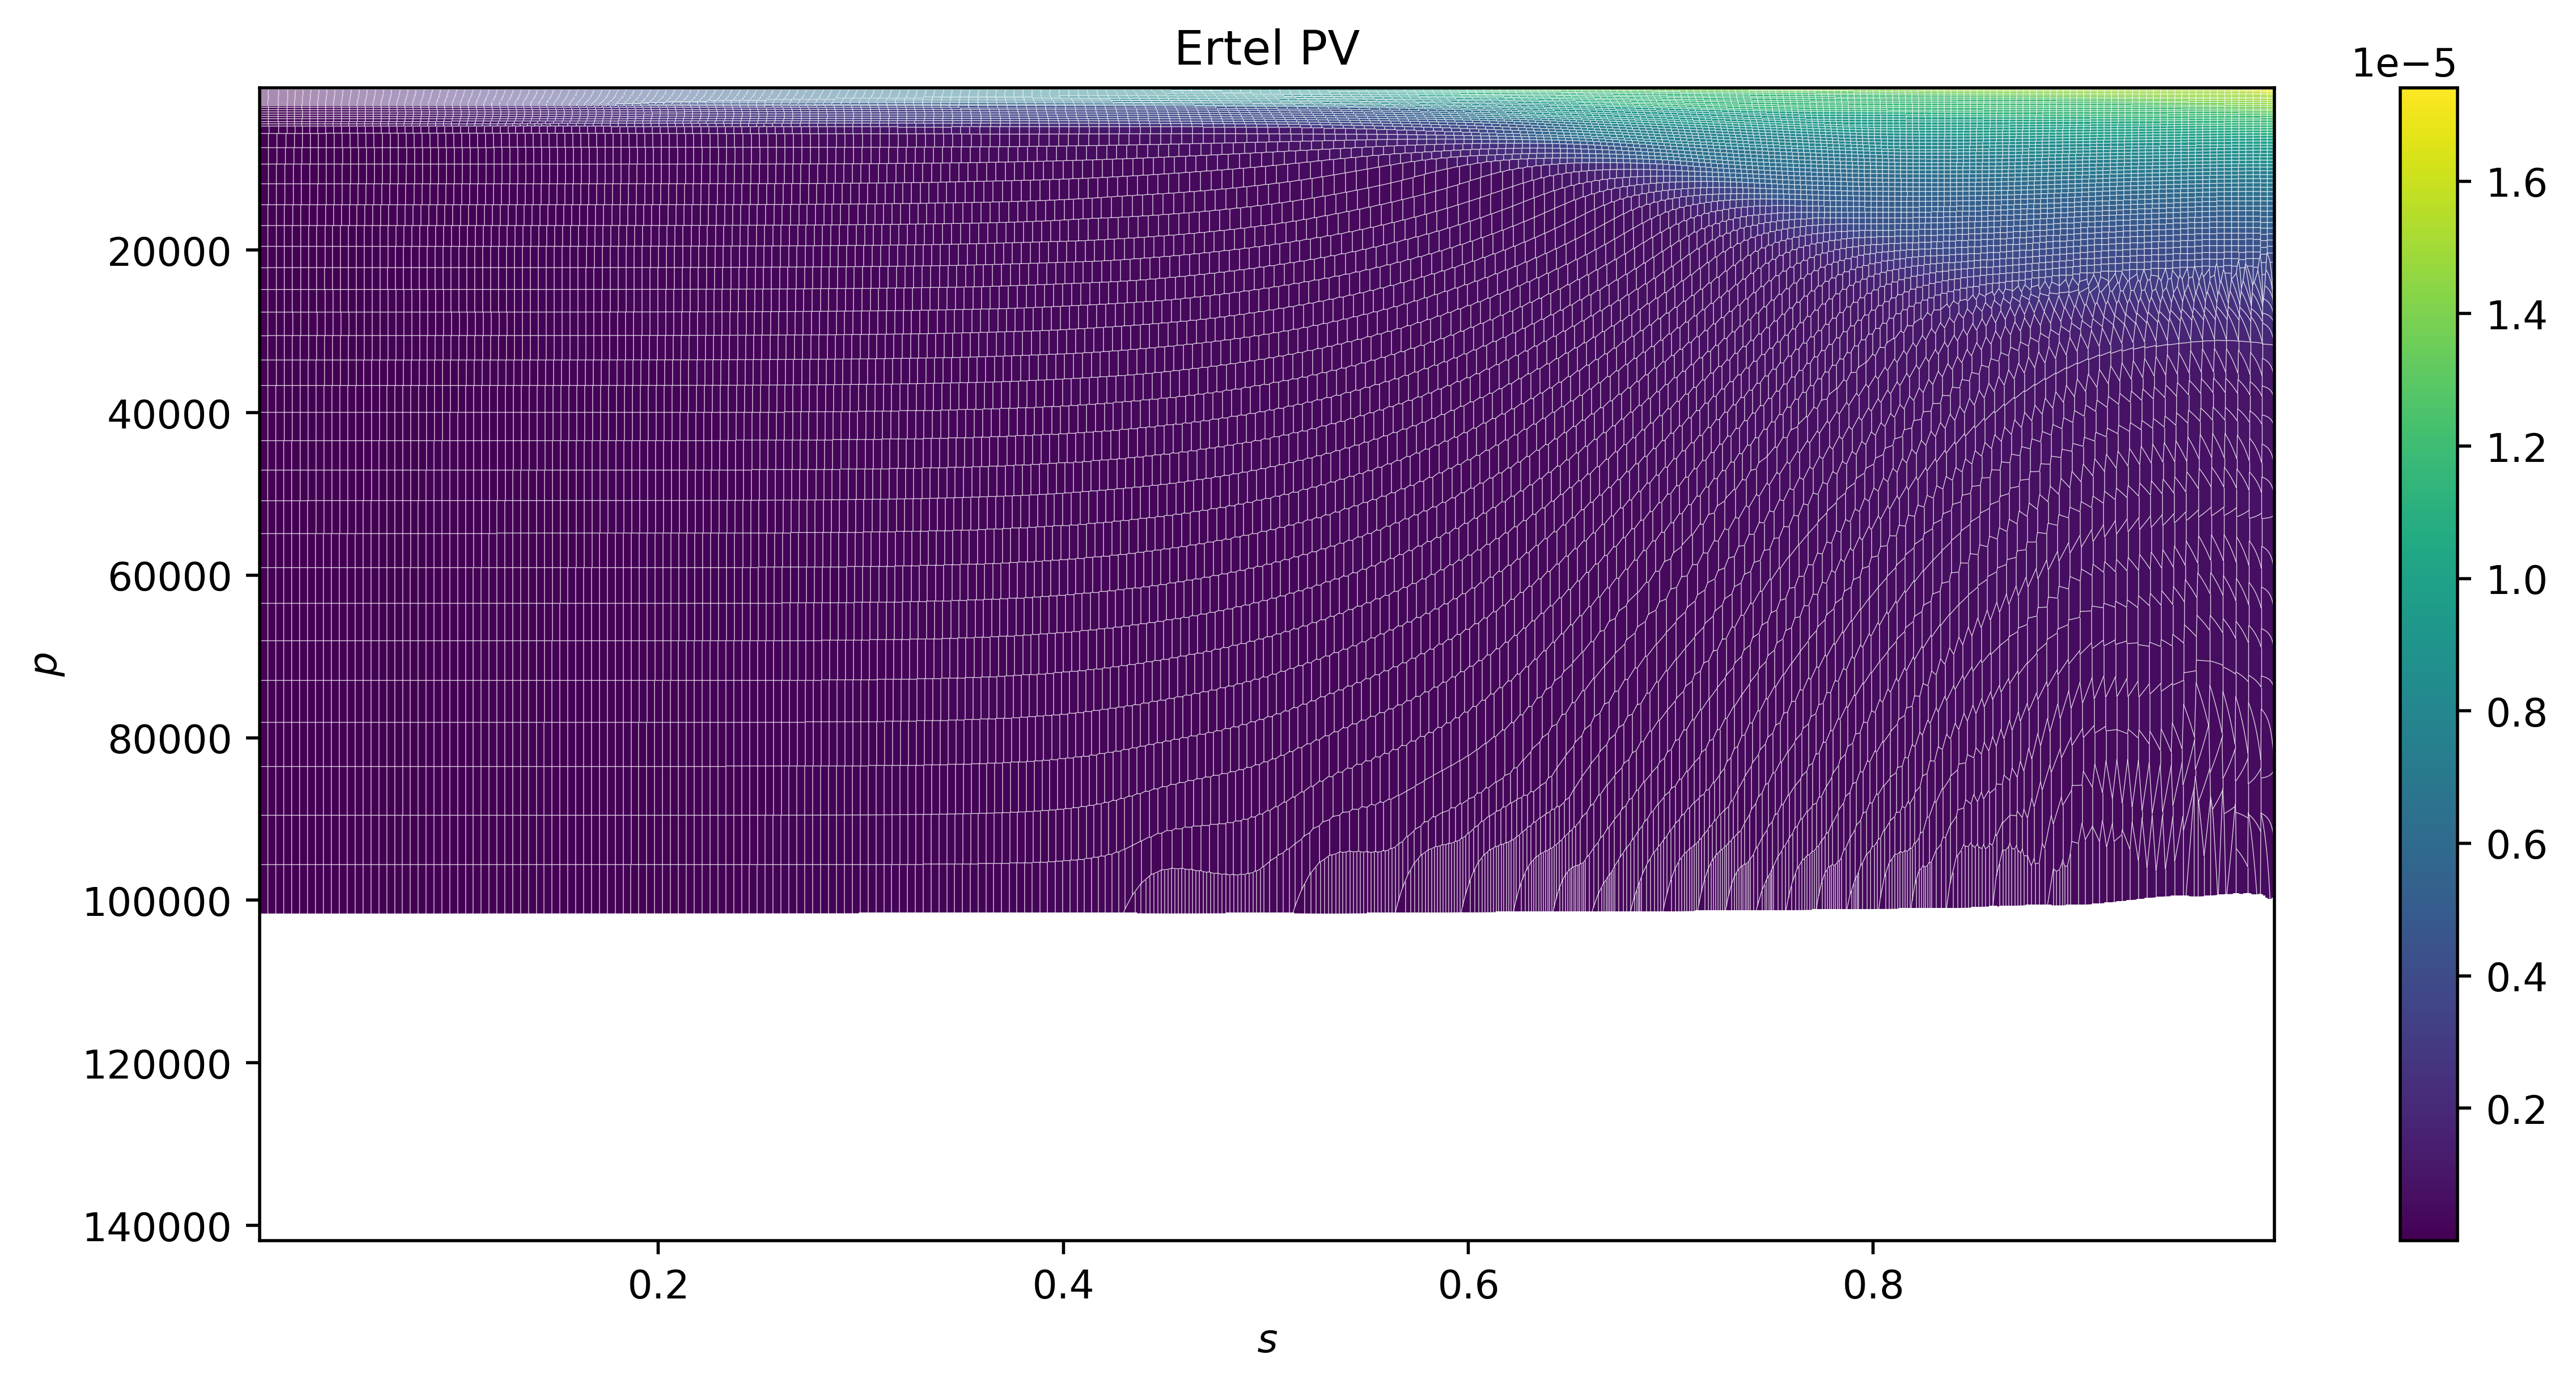

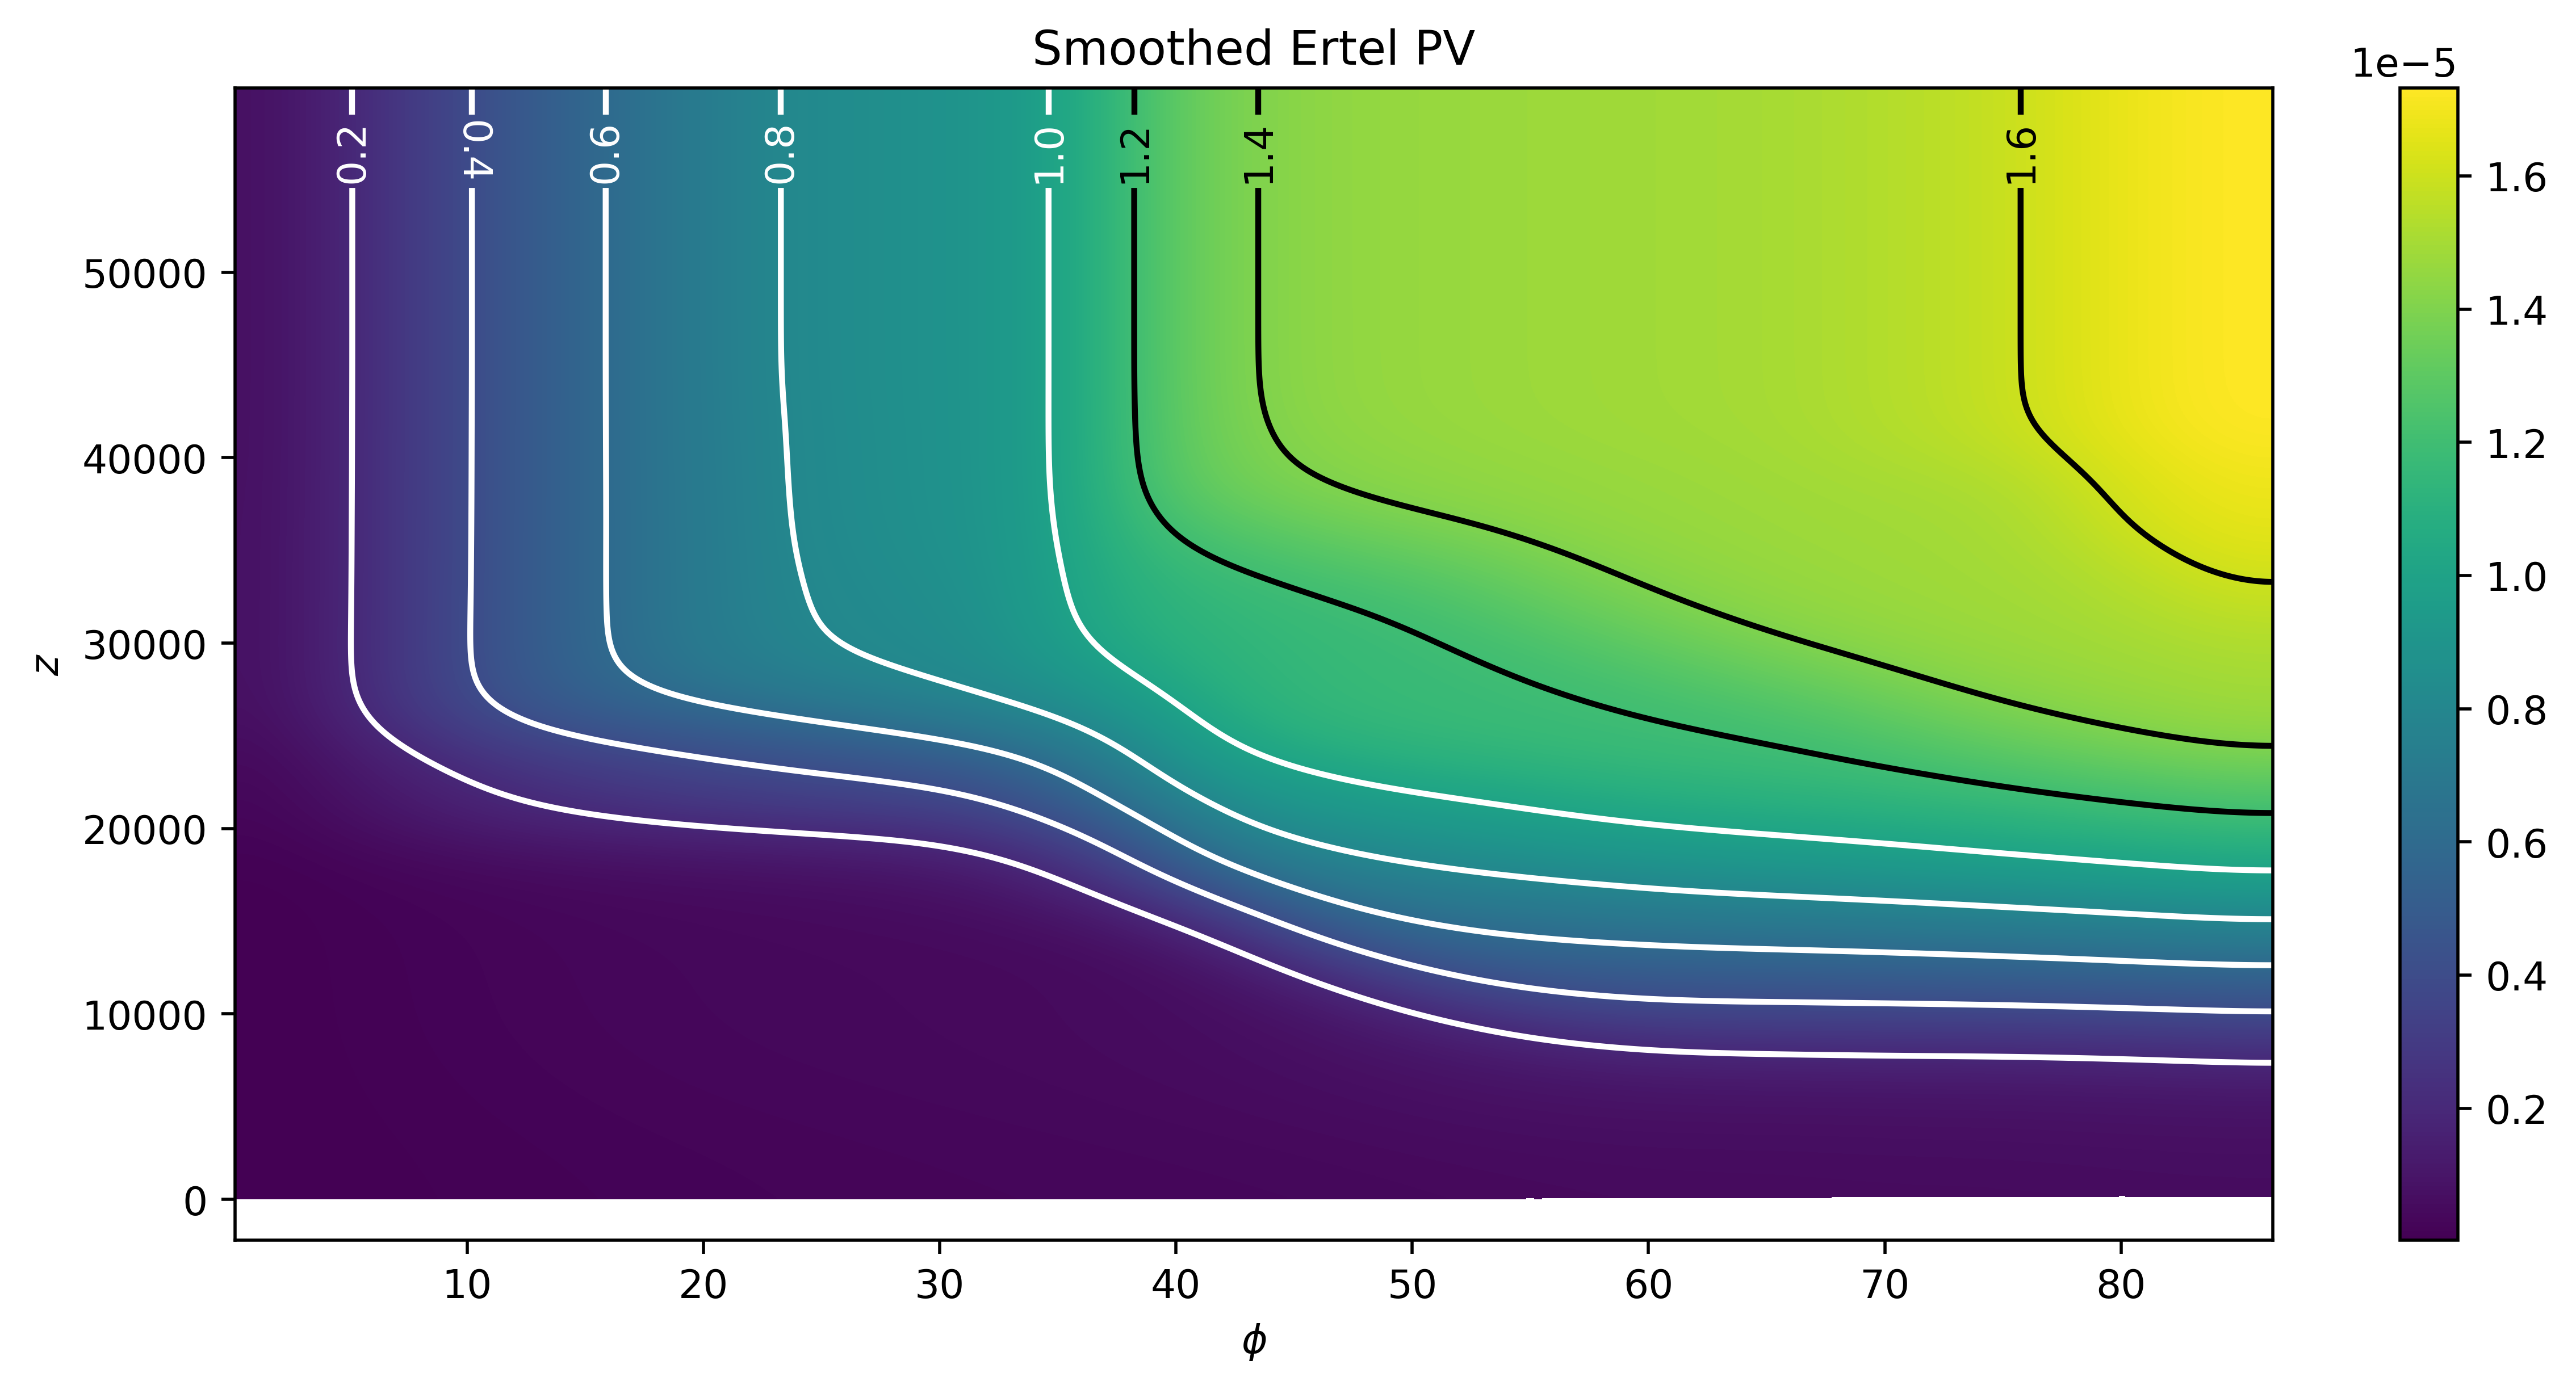

In [18]:
epv = data.epv

rv, ax = atmosphere_bgs.plot_lag_tess(val=epv, title = 'Ertel PV', **kwargs_s_p)
ax.set_xlabel('$s$')
ax.set_ylabel('$p$')

rv, ax = atmosphere_bgs.plot_lag_tess(val=epv, title = 'Smoothed Ertel PV', **kwargs_lat_z)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$z$')

# Saving and loading results

The 'solution' of the problem is essentially the dual variables, which are stored in the Laguerre diagram class. That is ```solv.ld.duals```. To reconstruct the optimal Laguerre diagram it is enough to have the seeds ```solv.y```, the duals ```solv.ld.duals```, the physical parameters ```solv.pp```, and the simulation parameters ```solv.sp``` (these contain the minimum pressure).
Below is an example of how to save and load these parameters using the python `pickle` module.

In [19]:
save_dict = {'y' : solv.y, 'duals' : solv.ld.duals, 'tmn' : solv.tmn, 'pp' : solv.pp, 'sp' : solv.sp}
save_name = 'example_solution.pkl'

with open(save_name, 'wb') as f:
    pickle.dump(save_dict, f)

In [ ]:
with open(save_name, 'rb') as f:
    soln_dict = pickle.load(f)
    
y = soln_dict['y']
duals = soln_dict['duals']
tmn = soln_dict['tmn']
pp = soln_dict['pp']
sp = soln_dict['sp']

ld = atmosphere_bgs.LaguerreDiagram(y,duals,pp,sp)

# calculate values to fill cells with
val = y[:,0]

# use predefined plotting function (see the docstring for arguments)
rv, ax = atmosphere_bgs.plot_lag_tess(ld, val);

fixed 0 intersects
